<h1>Predicting Rain in Australia</h1>

<h2>Table of Contents</h2>
<ul>
  <li><a href="#section1">1. Project Description</a></li>
  <li><a href="#section2">2. Data Understanding</a></li>
  <li><a href="#section3">3. Exploratory Data Analysis (EDA)</a></li>
  <li><a href="#section4">4. Data Preprocessing</a></li>
  <li><a href="#section5">5. Model Selection</a></li>
  <li><a href="#section6">6. Model Training & Evaluation</a></li>
  <li><a href="#section7">7. Hyperparameter Tuning</a></li>
  <li><a href="#section8">8. Final Evaluation & Model Saving</a></li>
  <li><a href="#section9">9. Feature Importance / Explainability</a></li>
  <li><a href="#section10">10. Conclusions & Next Steps</a></li>
</ul>

<a id='section1'></a>
## 1. Project Description

**Domain and Data Understanding**

The dataset our group uses is called “Rain in Australia.” It originates from the Australian Bureau of Meteorology and comprises about 10 years (2007–2017) of daily weather observations from locations across Australia. The data were collected from multiple weather stations and are openly accessible online (http://www.bom.gov.au/climate/data). The dataset consists of 23 attributes and approximatly 145,000 observations, including both numerical and categorical variables. Example feature groups include date and location, temperature, rainfall and related indicators, humidity, pressure, wind, and cloud cover. The main target variable (the last column) is RainTomorrow, which indicates whether it will rain on the following day. Several variables contain a substantial amount of missing values, which we will need to address during data cleaning.

**Project Statement and Goals**

Predicting rain in Australia is crucial for several reasons. Accurate rainfall forecasts are essential for planning daily activities and managing city operations, making life more predictable and convenient (Sarasa-Cabezuelo, 2022). The farming and food sectors highly depend on rainfall for planting, scheduling, and crop protection (Banik & Biswas, 2025). Because these sectors provide basic necessities for survival, farmers need to have accurate data to plan and react to upcoming weather.

Rainfall data are also important for predicting and managing extreme hydrological events (Lettenmaier, 2024). Understanding rainfall trends helps with the future prevention of flood risk and drought. Australia is a country with high climate variability; its rainfall is characterized by periods of extremely heavy rain and drought. For example, it experienced its driest 24-month period on record in the lead-up to the end of June 2020. Such a climate has strong impacts on both the environment and society (ARC Centre of Excellence for Climate Extremes, 2022).

Based on the reasons above, our main research question is:

**Given today’s weather conditions at a specific Australian location, can we predict whether it will rain tomorrow?**

We treat this as a supervised binary classification problem, where the target variable RainTomorrow indicates whether at least 1 mm of rain will fall on the following day. We also aim to identify which variables most strongly influence this dependent variable and, if necessary, to build new features by combining existing ones.

Our project consists of the following goals:
1. Understand and prepare data - Exploratory data analysis, handle missing data, and conduct additional features for later analysis
2. Build, train, and compare several machine learning models
3. Evaluate and compare model performances using suitable classification metrics
4. Interpret results and identify key weather variables strongly associated with the targeted variable

<a id='section2'></a>
## 2. Data Understanding

### 2.1 Loading Data and imports

In [10]:
# CORE LIBRARIES
import numpy as np
import pandas as pd

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPROCESSING
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# MACHINE LEARNING MODELS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from ogboost import GradientBoostingOrdinal  # ordinal classification model
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

#SPLITTING DATA SETS INTO TRAINING AND VALIDATION SETS
from sklearn.model_selection import train_test_split

# MODEL EVALUATION METRICS
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    mean_absolute_error,
    make_scorer
)

In [11]:
df = pd.read_csv('weatherAUS.csv')
print(df.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [12]:
# Number of observation and variables
df.shape

(145460, 23)

In [13]:
# Checking if there are duplicated rows
df.duplicated().sum()

np.int64(0)

In [14]:
# Shows the features --- What is the target variable?
print('Features: ', [col for col in df.columns if col != 'RainTomorrow'])

Features:  ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [15]:
# Checks the data types of the variables
df.dtypes
#Aissata: the data types seem to be correct for each feature, so we will use them as they are to define column types.

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [16]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### 2.2 Definition of General Variables
Defining General Variables helps...

Aissata: removed ordinal/nominal features because all categorical features seem to be nominal, so no need to distinguish. Also updated the code logic for simplicity.

Nils: isn't Cloud9am and Cloud3pm ordinal? Scores from 0-8 stands for 'Clear sky'- 'Overcast'. But never sure about this.
--> Correct! Updated the code (Aissata).

In [18]:
target = 'RainTomorrow'
features = [col for col in df.columns if col != target]

numerical_features = [col for col in df.columns if col in features and df[col].dtype == 'float64']

categorical_features = [col for col in df.columns if col in features and col not in numerical_features]


ordinal_categorical_features = ['Cloud3pm', 'Cloud9am']
nominal_categorical_features = list(set(categorical_features) - set(ordinal_categorical_features))

print('Target variable: ', target)
print('All features: ', features)
print('Numerical features: ', numerical_features)
print('Categorical features: ', categorical_features)
print('Ordinal categorical features: ', ordinal_categorical_features)
print('Nominal categorical features: ', nominal_categorical_features)

Target variable:  RainTomorrow
All features:  ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
Numerical features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Ordinal categorical features:  ['Cloud3pm', 'Cloud9am']
Nominal categorical features:  ['Date', 'RainToday', 'Location', 'WindDir9am', 'WindGustDir', 'WindDir3pm']


<a id='section3'></a>
## 3. Exploratory Data Analysis (EDA)

TODO
- Check target distribution
- Univariate & bivariate analysis
- Correlation heatmap
- Outlier inspection

We start with Explorator Data Analysis to explore distribution, patterns and relationships between the variables.

In [20]:
df_eda = df.copy()


### 3.1 Minimal Data Cleaning for Exploratory Data Analysis

> Nils: Is this always the same? And can I do it like in your hospital project?
- Missing data
- Categorical variables / features
- Inconsistent Data Types
- Detection and outliers



#### Missing Values

In [21]:
df_eda.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Aissata: We have a lot of missing values. We will have to really justify what we do with these.

#### Identifying and capping outliers in numerical variables

Nils: How should we define outliers? There is a great number of 'outliers'.
Nils: Labeling of data according to Kaggel documentation

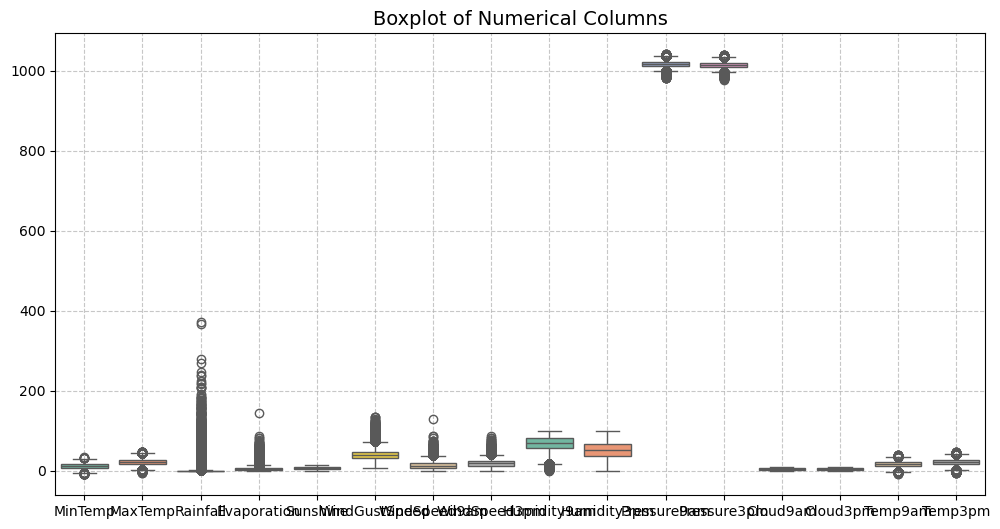

MinTemp:
 - Lower bound: 0
 - Upper bound: 30.849999999999998
 - Number of outliers: 3472

MaxTemp:
 - Lower bound: 2.4499999999999975
 - Upper bound: 43.65
 - Number of outliers: 489

Rainfall:
 - Lower bound: 0
 - Upper bound: 2.0
 - Number of outliers: 25578

Evaporation:
 - Lower bound: 0
 - Upper bound: 14.600000000000001
 - Number of outliers: 1995

Sunshine:
 - Lower bound: 0
 - Upper bound: 19.299999999999997
 - Number of outliers: 0

WindGustSpeed:
 - Lower bound: 5.5
 - Upper bound: 73.5
 - Number of outliers: 3092

WindSpeed9am:
 - Lower bound: 0
 - Upper bound: 37.0
 - Number of outliers: 1817

WindSpeed3pm:
 - Lower bound: 0
 - Upper bound: 40.5
 - Number of outliers: 2523

Humidity9am:
 - Lower bound: 18.0
 - Upper bound: 122.0
 - Number of outliers: 1425

Humidity3pm:
 - Lower bound: 0
 - Upper bound: 109.5
 - Number of outliers: 0

Pressure9am:
 - Lower bound: 998.65
 - Upper bound: 1036.65
 - Number of outliers: 1191

Pressure3pm:
 - Lower bound: 996.0
 - Upper bound: 

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_eda[numerical_features], palette="Set2")
plt.title("Boxplot of Numerical Columns", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Here we calculate IQR boundaries for each numeric column
for col in numerical_features:
    Q1 = df_eda[col].quantile(0.25)
    Q3 = df_eda[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if lower < 0:
        lower = 0

    outliers = df_eda[(df[col] < lower) | (df_eda[col] > upper)][col].count()
    print(f"{col}:")
    print(f" - Lower bound: {lower}")
    print(f" - Upper bound: {upper}")
    print(f" - Number of outliers: {outliers}\n")

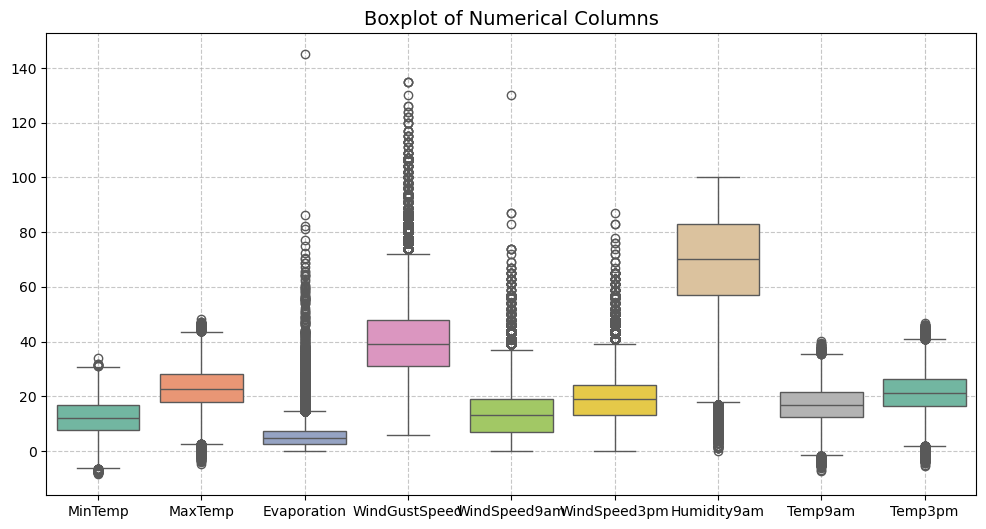

MinTemp:
 - Lower bound: 0
 - Upper bound: 30.849999999999998
 - Number of outliers: 3472

MaxTemp:
 - Lower bound: 2.4499999999999975
 - Upper bound: 43.65
 - Number of outliers: 489

Rainfall:
 - Lower bound: 0
 - Upper bound: 2.0
 - Number of outliers: 25578

Evaporation:
 - Lower bound: 0
 - Upper bound: 14.600000000000001
 - Number of outliers: 1995

Sunshine:
 - Lower bound: 0
 - Upper bound: 19.299999999999997
 - Number of outliers: 0

WindGustSpeed:
 - Lower bound: 5.5
 - Upper bound: 73.5
 - Number of outliers: 3092

WindSpeed9am:
 - Lower bound: 0
 - Upper bound: 37.0
 - Number of outliers: 1817

WindSpeed3pm:
 - Lower bound: 0
 - Upper bound: 40.5
 - Number of outliers: 2523

Humidity9am:
 - Lower bound: 18.0
 - Upper bound: 122.0
 - Number of outliers: 1425

Humidity3pm:
 - Lower bound: 0
 - Upper bound: 109.5
 - Number of outliers: 0

Pressure9am:
 - Lower bound: 998.65
 - Upper bound: 1036.65
 - Number of outliers: 1191

Pressure3pm:
 - Lower bound: 996.0
 - Upper bound: 

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_eda[['MinTemp','MaxTemp', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Temp9am', 'Temp3pm']], palette="Set2")
plt.title("Boxplot of Numerical Columns", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Here we calculate IQR boundaries for each numeric column
for col in numerical_features:
    Q1 = df_eda[col].quantile(0.25)
    Q3 = df_eda[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if lower < 0:
        lower = 0

    outliers = df_eda[(df[col] < lower) | (df_eda[col] > upper)][col].count()
    print(f"{col}:")
    print(f" - Lower bound: {lower}")
    print(f" - Upper bound: {upper}")
    print(f" - Number of outliers: {outliers}\n")

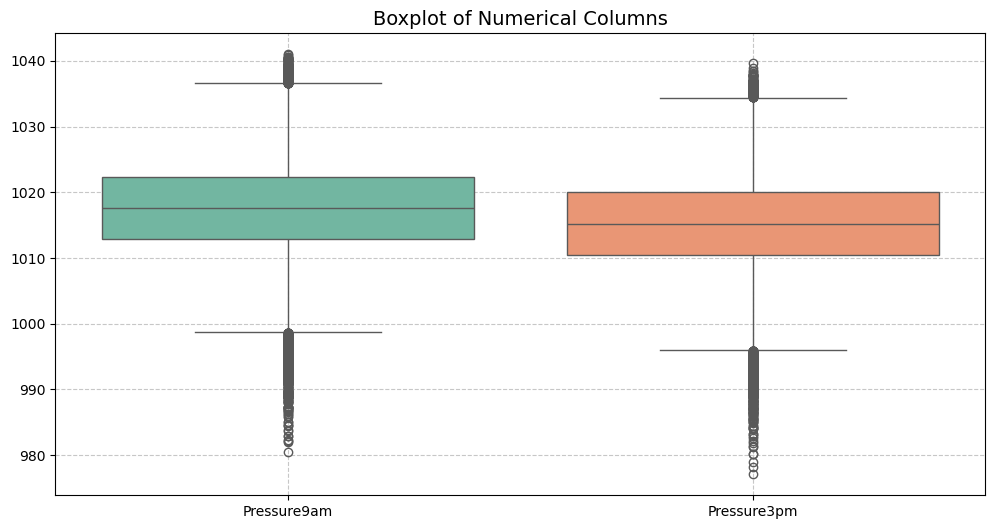

MinTemp:
 - Lower bound: 0
 - Upper bound: 30.849999999999998
 - Number of outliers: 3472

MaxTemp:
 - Lower bound: 2.4499999999999975
 - Upper bound: 43.65
 - Number of outliers: 489

Rainfall:
 - Lower bound: 0
 - Upper bound: 2.0
 - Number of outliers: 25578

Evaporation:
 - Lower bound: 0
 - Upper bound: 14.600000000000001
 - Number of outliers: 1995

Sunshine:
 - Lower bound: 0
 - Upper bound: 19.299999999999997
 - Number of outliers: 0

WindGustSpeed:
 - Lower bound: 5.5
 - Upper bound: 73.5
 - Number of outliers: 3092

WindSpeed9am:
 - Lower bound: 0
 - Upper bound: 37.0
 - Number of outliers: 1817

WindSpeed3pm:
 - Lower bound: 0
 - Upper bound: 40.5
 - Number of outliers: 2523

Humidity9am:
 - Lower bound: 18.0
 - Upper bound: 122.0
 - Number of outliers: 1425

Humidity3pm:
 - Lower bound: 0
 - Upper bound: 109.5
 - Number of outliers: 0

Pressure9am:
 - Lower bound: 998.65
 - Upper bound: 1036.65
 - Number of outliers: 1191

Pressure3pm:
 - Lower bound: 996.0
 - Upper bound: 

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_eda[['Pressure9am', 'Pressure3pm']], palette="Set2")
plt.title("Boxplot of Numerical Columns", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Here we calculate IQR boundaries for each numeric column
for col in numerical_features:
    Q1 = df_eda[col].quantile(0.25)
    Q3 = df_eda[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if lower < 0:
        lower = 0

    outliers = df_eda[(df[col] < lower) | (df_eda[col] > upper)][col].count()
    print(f"{col}:")
    print(f" - Lower bound: {lower}")
    print(f" - Upper bound: {upper}")
    print(f" - Number of outliers: {outliers}\n")

#### Encoding Categorical Variables

Nils: tbd how we encode the categorical features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [25]:
# Mapping Wind Direction to values from 0 to 15
wind_order = [
    'W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE', 'S', 'NW', 'SE', 'ESE', 'E', 'SSW'
]

wind_dir_mapping = {
    'W': 0,
    'WNW': 1,
    'WSW': 2,
    'NE': 3,
    'NNW': 4,
    'N': 5,
    'NNE': 6,
    'SW': 7,
    'ENE': 8,
    'SSE': 9,
    'S': 10,
    'NW': 11,
    'SE': 12,
    'ESE': 13,
    'E': 14,
    'SSW':15
}

wind_dir_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

for col in wind_dir_cols:
    df[col] = df[col].map(wind_dir_mapping)

# Mapping Binary Values to values from 0 and 1
binary_map = {'No': 0, 'Yes': 1}
binary_cols = ['RainToday', 'RainTomorrow']

for col in binary_cols:
    df[col] = df[col].map(binary_map)

In [26]:
# Define explicit orders for categorical features
categorical_orders = {
    'Date': [], # Nils: devide in Year, Month, Days and match it to Sin / Cos to represent the seasonal trend?
    'Location': [], # Nils: do we need to encode Location?
    'WindGustDir':
        [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ], # Nils: Match Direction to 360 degree?
    'WindDir9am': [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ],
    'WindDir3pm': [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ],
    'RainToday': [True, False],
    'Cloud9am': [
        'Clear sky',
        'Almost clear',
        'Mostly clear',
        'Partly cloudy',
        "Half cloudy",
        'Mostly cloudy',
        'Very cloudy',
        'Nearly overcast',
        'Overcast'
    ],
    'Cloud3om': [
        'Clear sky',
        'Almost clear',
        'Mostly clear',
        'Partly cloudy',
        "Half cloudy",
        'Mostly cloudy',
        'Very cloudy',
        'Nearly overcast',
        'Overcast'
    ],
}
#### Encoding Categorical Variables


### 3.2 Univariate Analysis

- Check each variable for their data type and target distribution


##### Target

Aissata: Checking target distribution to see if it is balanced or not. Will determine if we stratify or not when splitting into test and training sets.

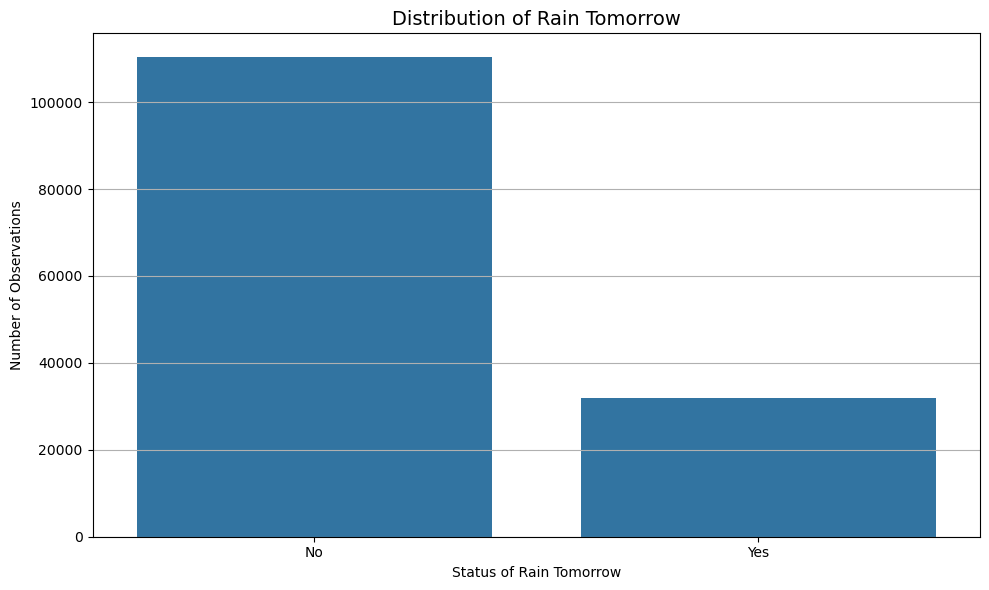

In [27]:
# Nils: makes it sense?
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=df_eda)
plt.title('Distribution of Rain Tomorrow', fontsize=14)
plt.xlabel('Status of Rain Tomorrow')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Since Target is imbalanced, we will apply stratification when splitting the data.

Class distribution:
RainTomorrow
0.0    0.775819
1.0    0.224181
Name: proportion, dtype: float64


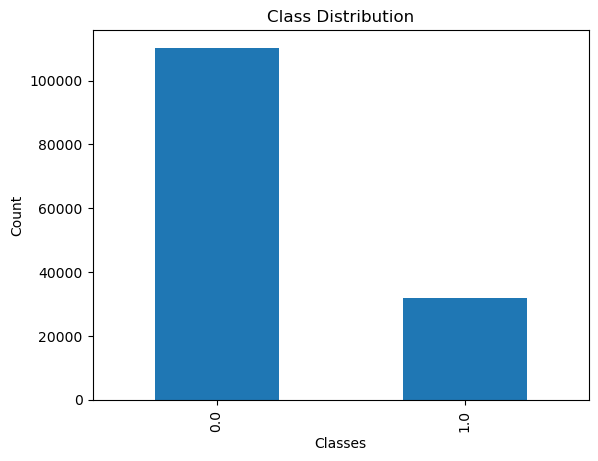

In [28]:
print("Class distribution:")
print(df[target].value_counts(normalize=True))  # relative frequencies

# Plot for better visualization
df[target].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

#### Categorical Variables Analysis
For the analysis of all categorical variables we will do the following:
- Map encoded numerica values back to text labels (Nils: first we need to encode them properly lol
- Apply mapping to create human-readable labels
- Plot distribution

##### Location

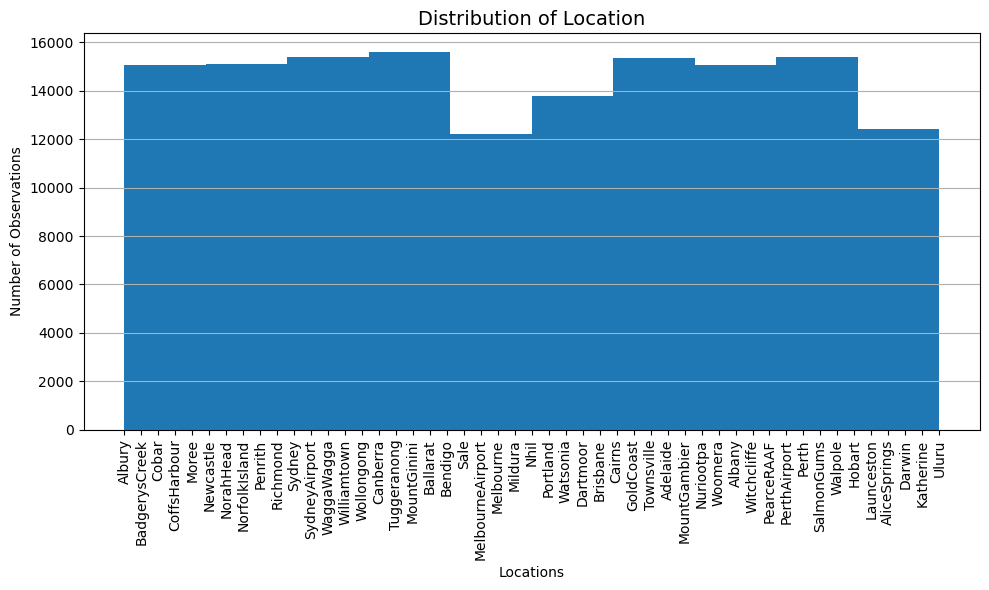

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Location'])
plt.title('Distribution of Location', fontsize=14)
plt.xlabel('Locations')
plt.ylabel('Number of Observations')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Gust Direction

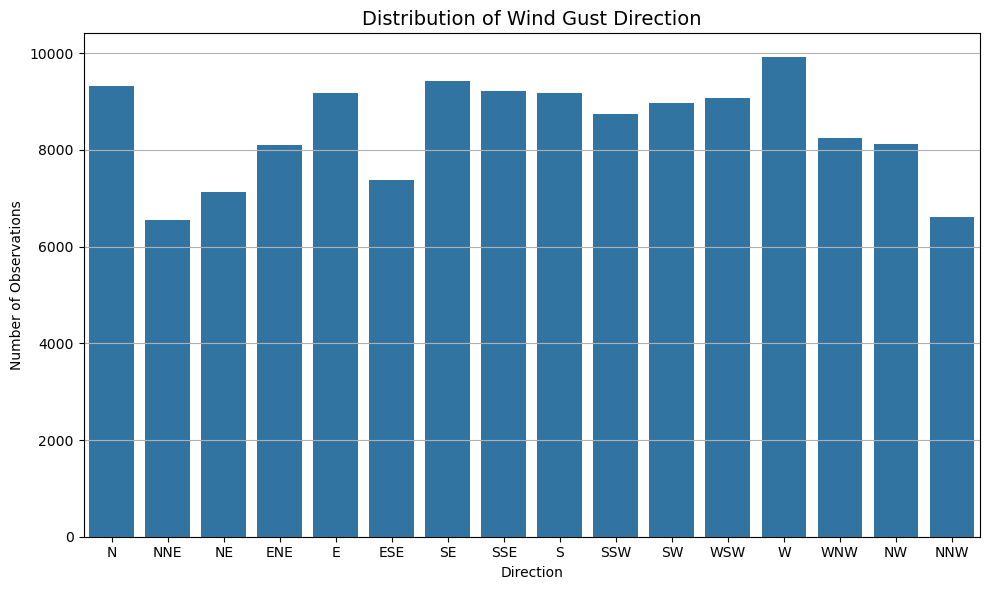

In [30]:
WindGustDir_order = [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ]

plt.figure(figsize=(10, 6))
sns.countplot(x=df_eda['WindGustDir'], order=WindGustDir_order)
plt.title('Distribution of Wind Gust Direction', fontsize=14)
plt.xlabel('Direction')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Direction 9am

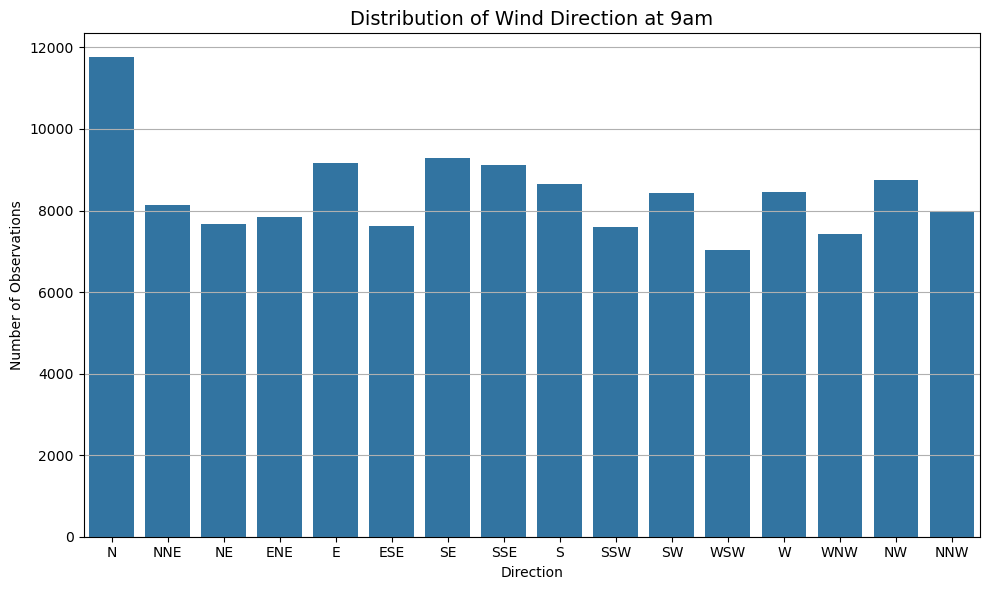

In [31]:
WindDir9am_order = [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ]

plt.figure(figsize=(10, 6))
sns.countplot(x=df_eda['WindDir9am'], order=WindDir9am_order)
plt.title('Distribution of Wind Direction at 9am', fontsize=14)
plt.xlabel('Direction')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Direction 3pm

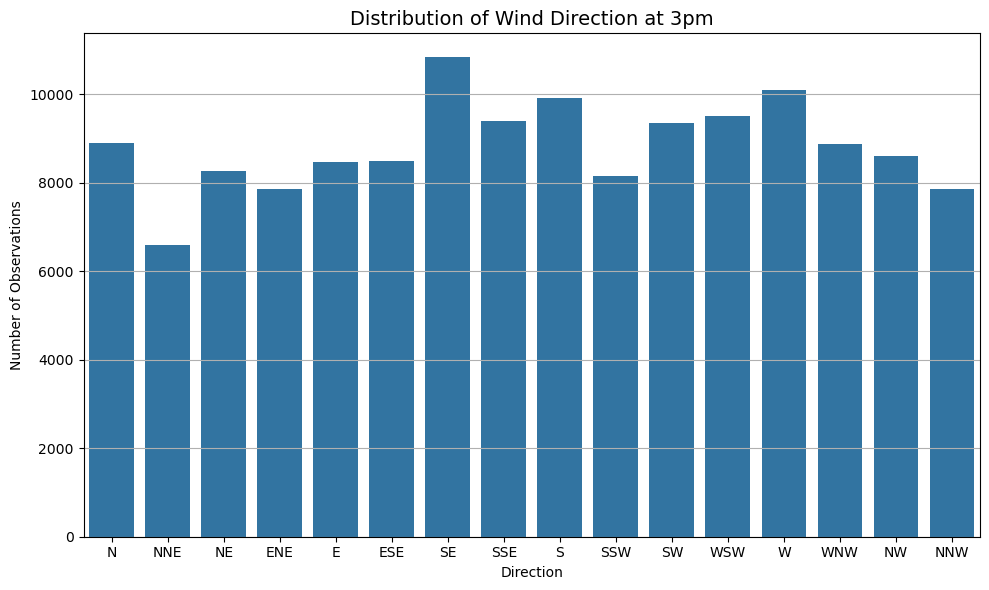

In [32]:
WindDir3pm_order = [
        'N', 'NNE', 'NE', 'ENE',
        'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW',
        'W', 'WNW', 'NW', 'NNW'
        ]

plt.figure(figsize=(10, 6))
sns.countplot(x=df_eda['WindDir3pm'], order=WindDir3pm_order)
plt.title('Distribution of Wind Direction at 3pm', fontsize=14)
plt.xlabel('Direction')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Rain Today

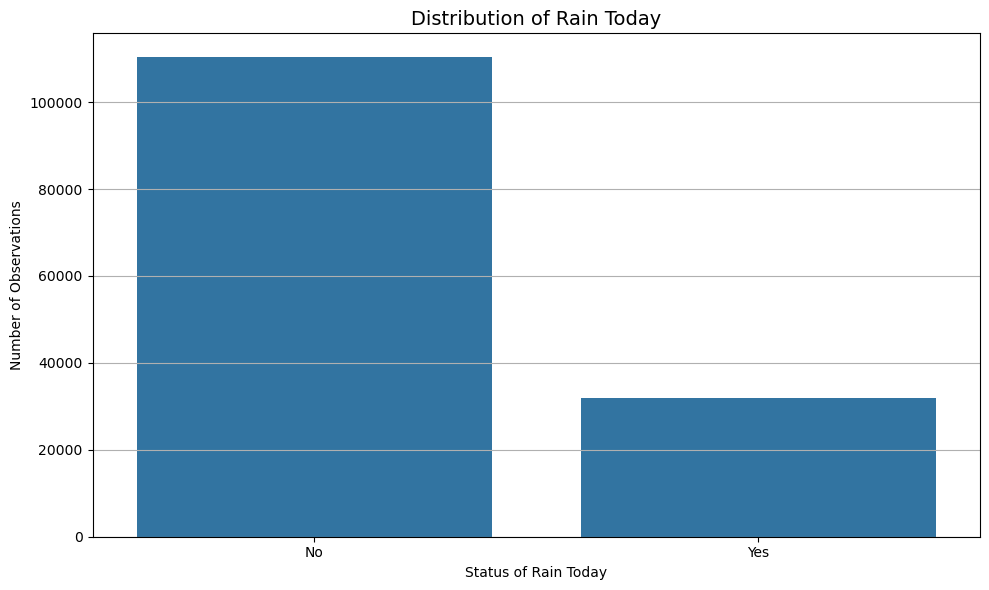

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_eda['RainToday'])
plt.title('Distribution of Rain Today', fontsize=14)
plt.xlabel('Status of Rain Today')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Cloud 9am

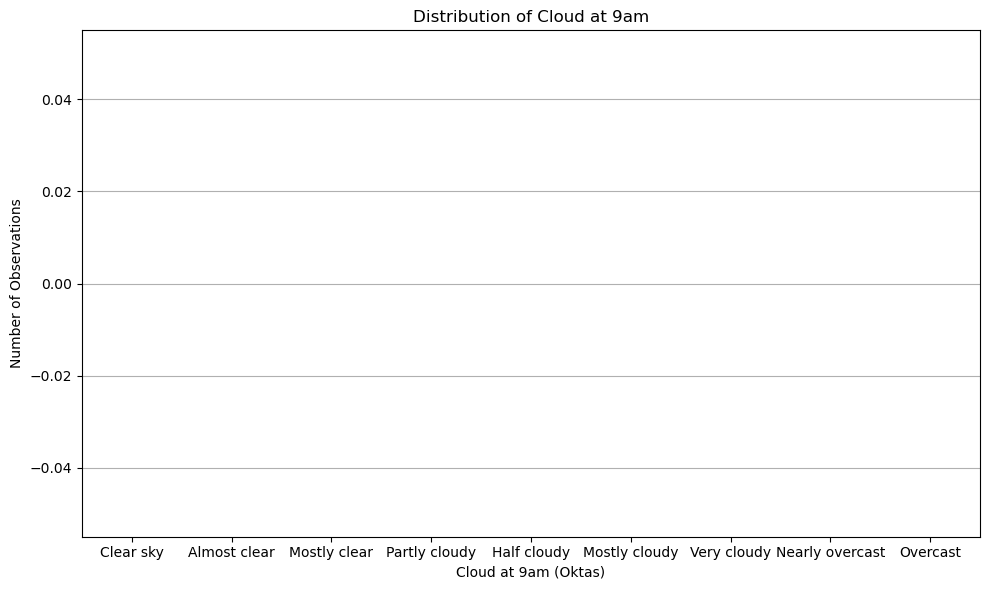

In [34]:
# does not show any data. will correct

Cloud9am_order = [
        'Clear sky',
        'Almost clear',
        'Mostly clear',
        'Partly cloudy',
        "Half cloudy",
        'Mostly cloudy',
        'Very cloudy',
        'Nearly overcast',
        'Overcast'
    ]

plt.figure(figsize=(10, 6))
sns.countplot(x=df_eda['Cloud9am'], order=Cloud9am_order)
plt.title('Distribution of Cloud at 9am')
plt.xlabel('Cloud at 9am (Oktas)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Numerical Variables Analysis

##### MinTemp

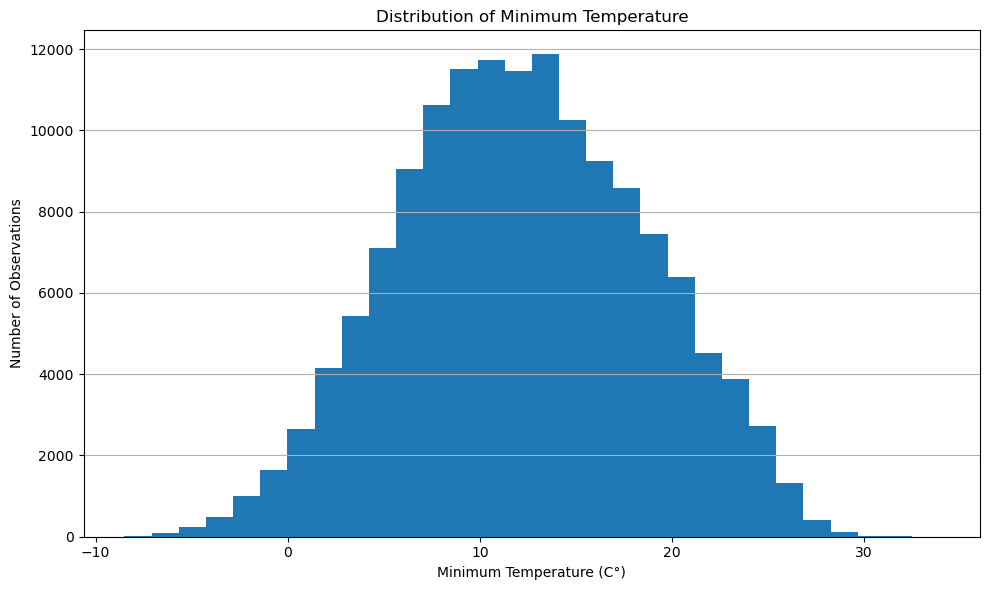

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['MinTemp'], bins=30)
plt.title('Distribution of Minimum Temperature')
plt.xlabel('Minimum Temperature (C°)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Maximum Temperature

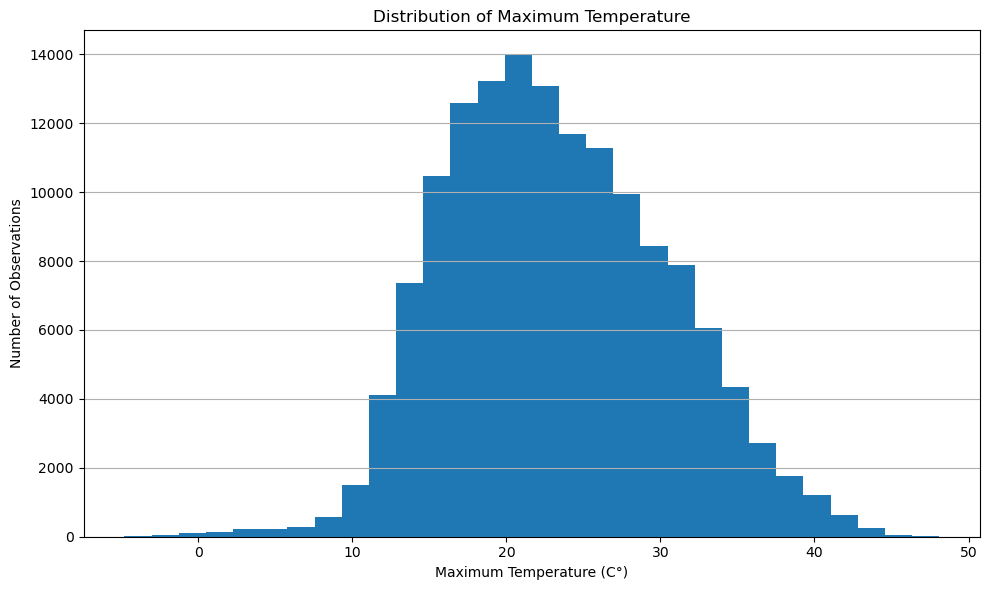

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['MaxTemp'], bins=30)
plt.title('Distribution of Maximum Temperature')
plt.xlabel('Maximum Temperature (C°)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Rainfall

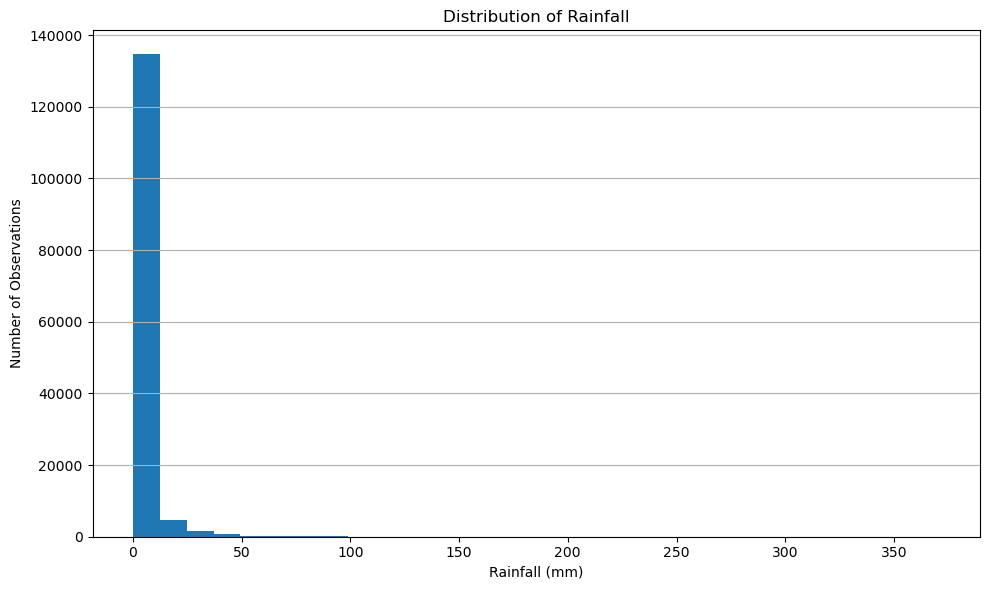

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Rainfall'], bins=30)
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

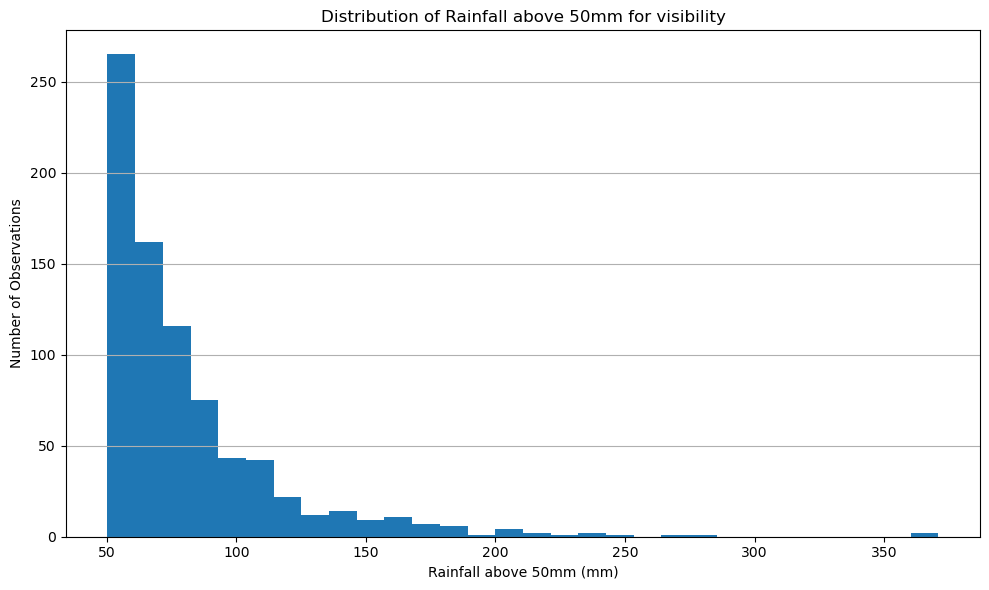

In [38]:
# filter rainfall histogram in an upper set to better display the distribution above 50mm

plt.figure(figsize=(10, 6))
plt.hist(x=df_eda[df_eda['Rainfall'] > 50]['Rainfall'], bins=30)
plt.title('Distribution of Rainfall above 50mm for visibility')
plt.xlabel('Rainfall above 50mm (mm)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


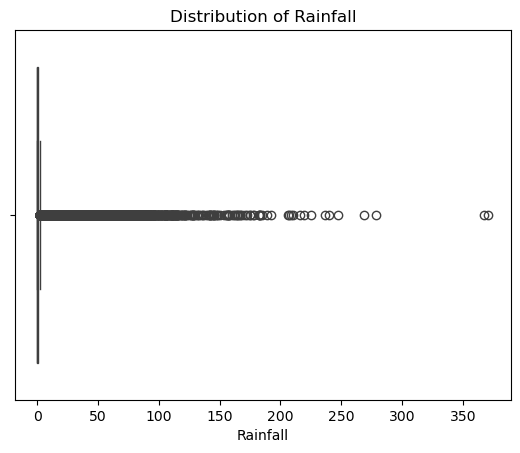

In [39]:
sns.boxplot(x=df_eda['Rainfall'])
plt.title('Distribution of Rainfall')
plt.show()

##### Evaporation

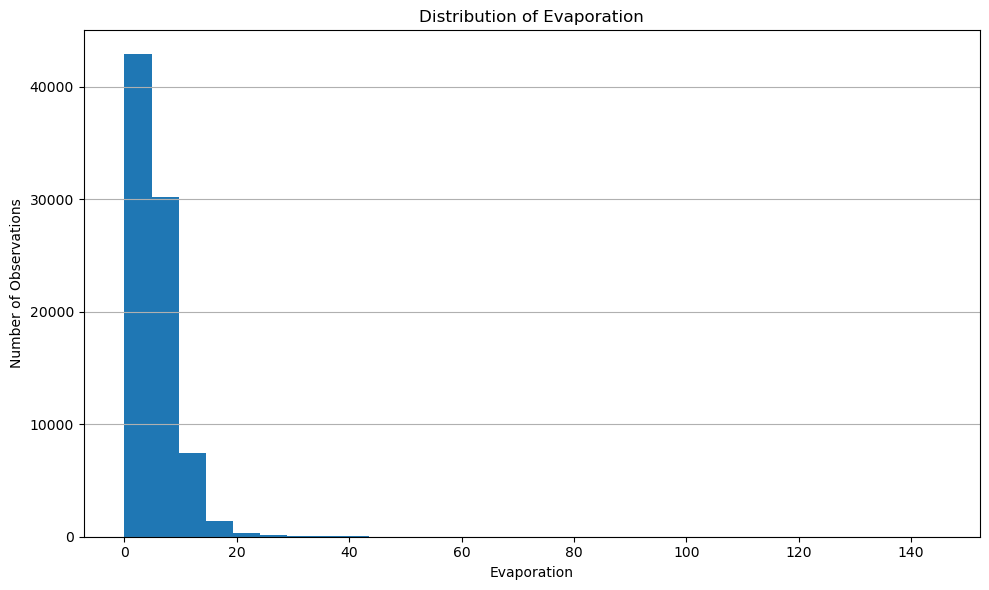

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Evaporation'], bins=30)
plt.title('Distribution of Evaporation')
plt.xlabel('Evaporation')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

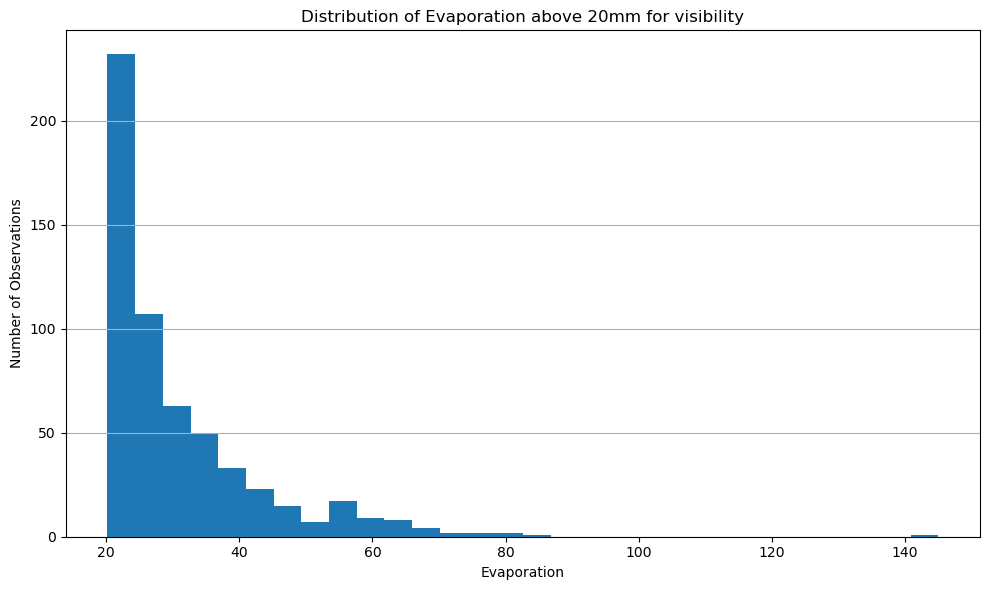

In [41]:
# filter rainfall histogram in an upper set to better display the distribution above 50mm
# Nils: should the threshold (20) follow some methodology?

plt.figure(figsize=(10, 6))
plt.hist(x=df_eda[df_eda['Evaporation'] > 20]['Evaporation'], bins=30)
plt.title('Distribution of Evaporation above 20mm for visibility')
plt.xlabel('Evaporation')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Sunshine

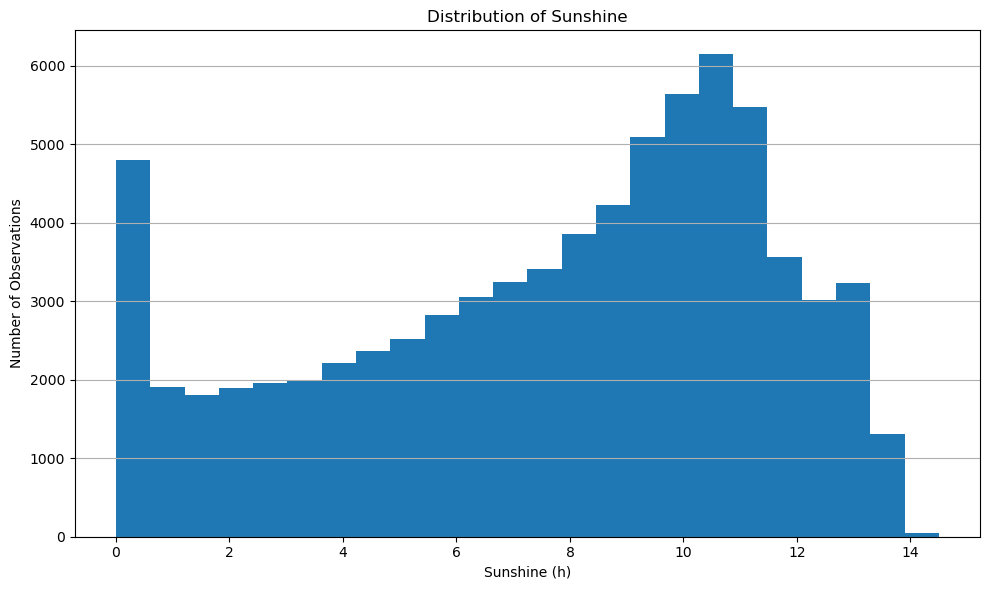

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Sunshine'], bins=24)
plt.title('Distribution of Sunshine')
plt.xlabel('Sunshine (h)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Gust Speed

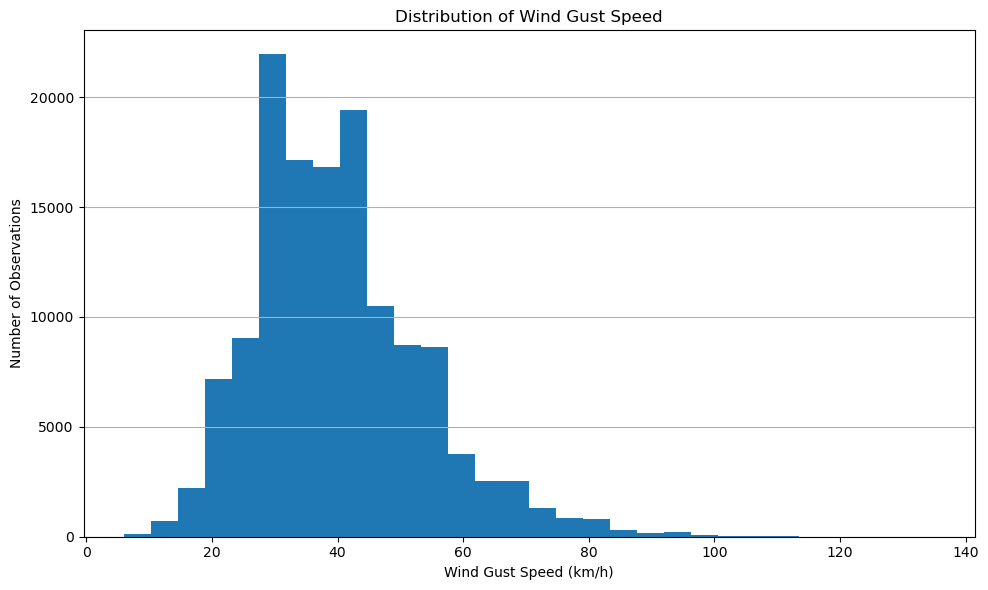

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['WindGustSpeed'], bins=30)
plt.title('Distribution of Wind Gust Speed')
plt.xlabel('Wind Gust Speed (km/h)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

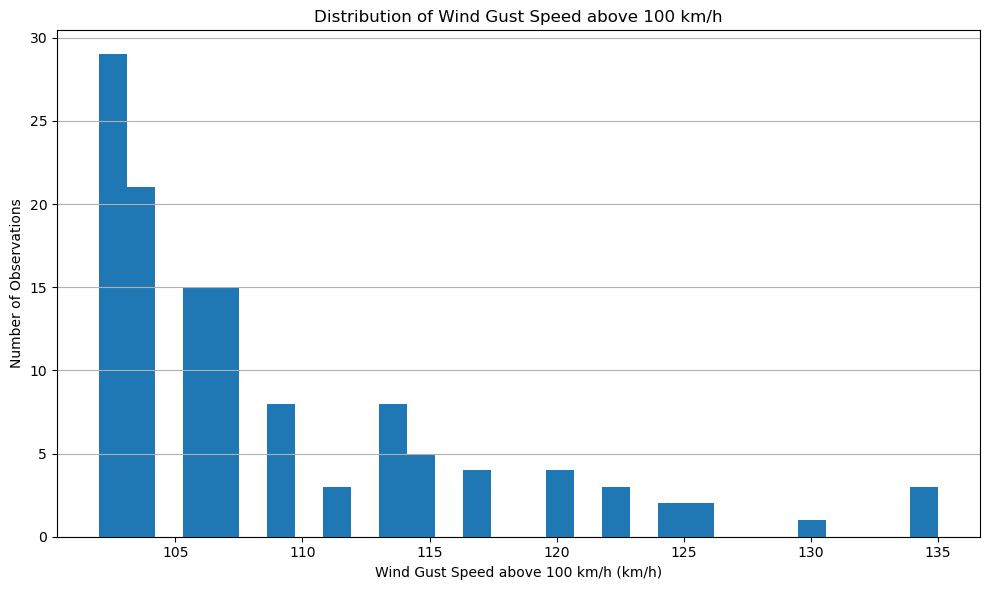

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda[df_eda['WindGustSpeed'] > 100 ]['WindGustSpeed'], bins=30)
plt.title('Distribution of Wind Gust Speed above 100 km/h')
plt.xlabel('Wind Gust Speed above 100 km/h (km/h)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Speed at 9am

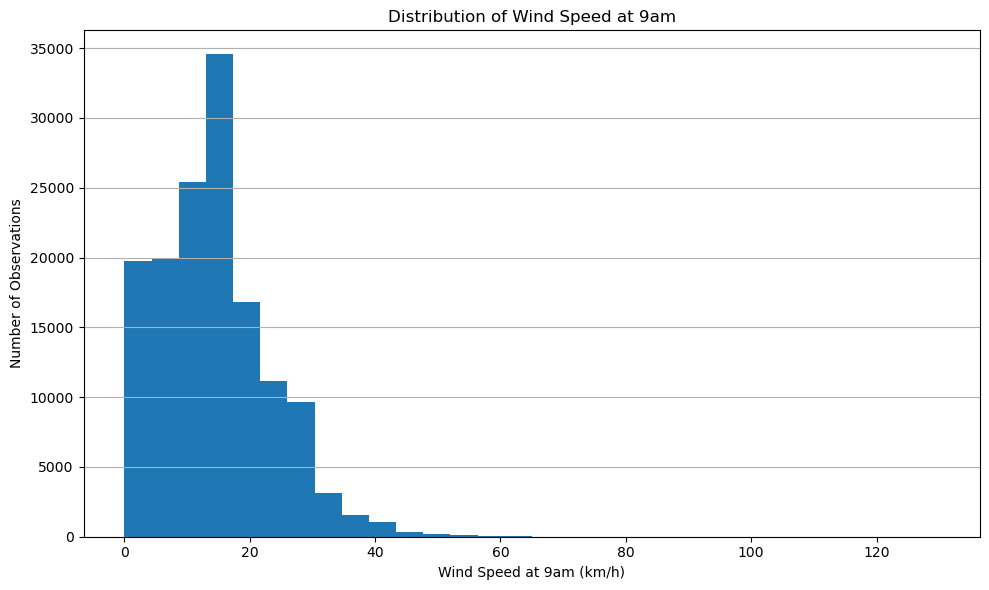

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['WindSpeed9am'], bins=30)
plt.title('Distribution of Wind Speed at 9am')
plt.xlabel('Wind Speed at 9am (km/h)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Wind Speed at 3pm

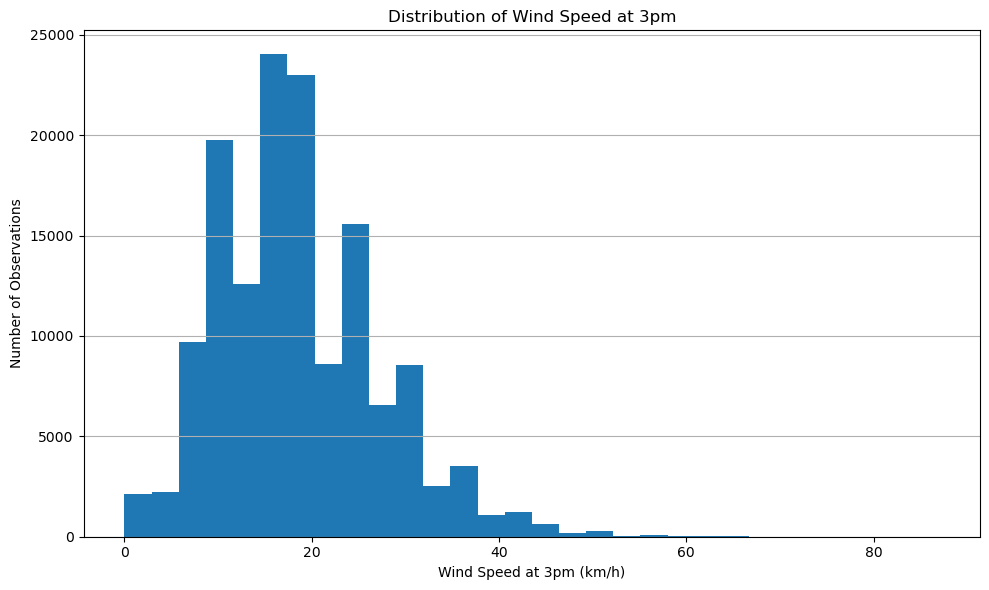

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['WindSpeed3pm'], bins=30)
plt.title('Distribution of Wind Speed at 3pm')
plt.xlabel('Wind Speed at 3pm (km/h)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Humidity 9am

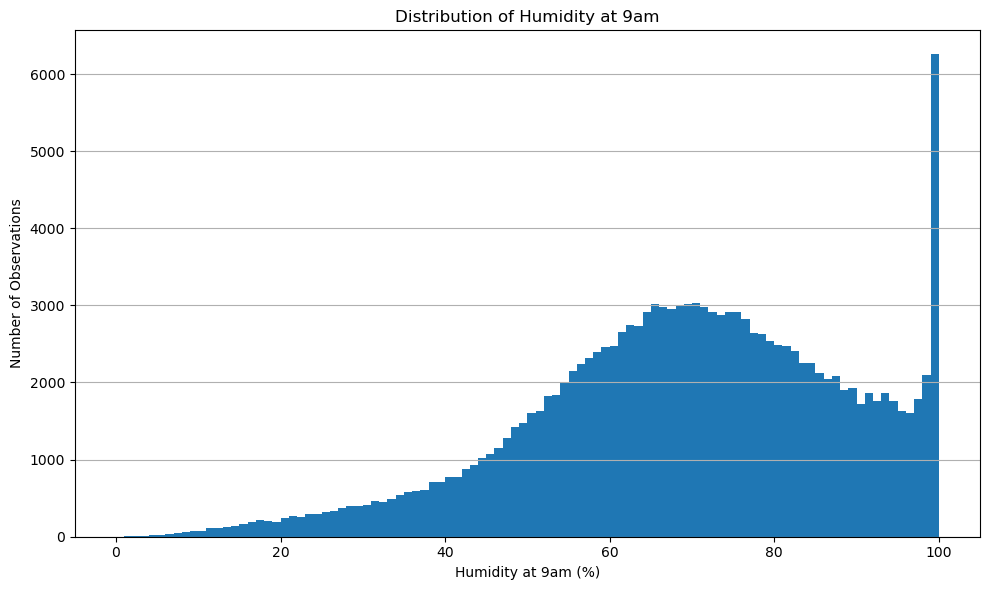

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Humidity9am'], bins=100)
plt.title('Distribution of Humidity at 9am')
plt.xlabel('Humidity at 9am (%)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Humanidity 3pm

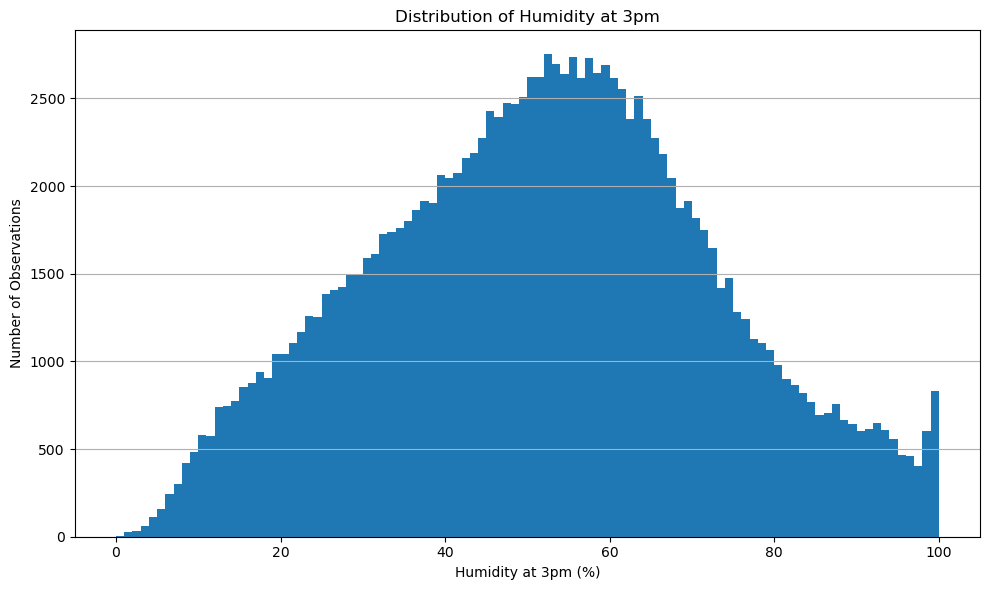

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Humidity3pm'], bins=100)
plt.title('Distribution of Humidity at 3pm')
plt.xlabel('Humidity at 3pm (%)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Pressure 9am

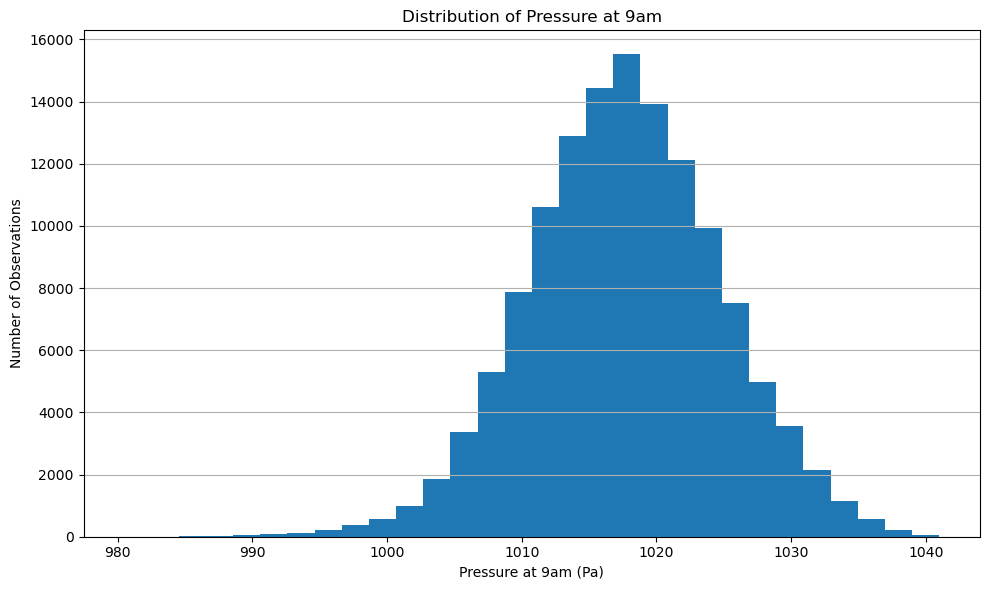

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Pressure9am'], bins=30)
plt.title('Distribution of Pressure at 9am')
plt.xlabel('Pressure at 9am (Pa)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Pressure 3pm

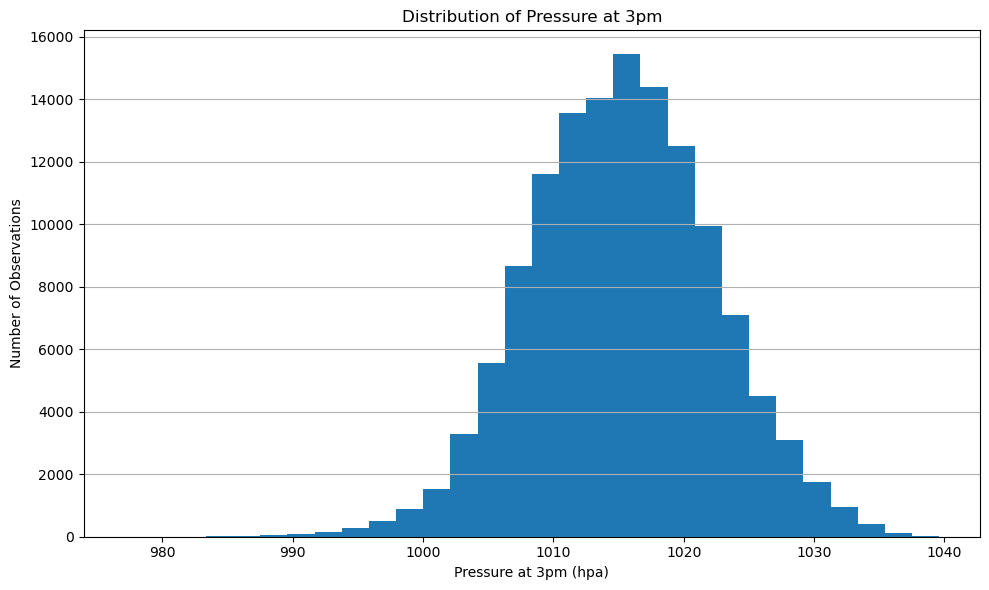

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Pressure3pm'], bins=30)
plt.title('Distribution of Pressure at 3pm')
plt.xlabel('Pressure at 3pm (hpa)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Temperature 9am

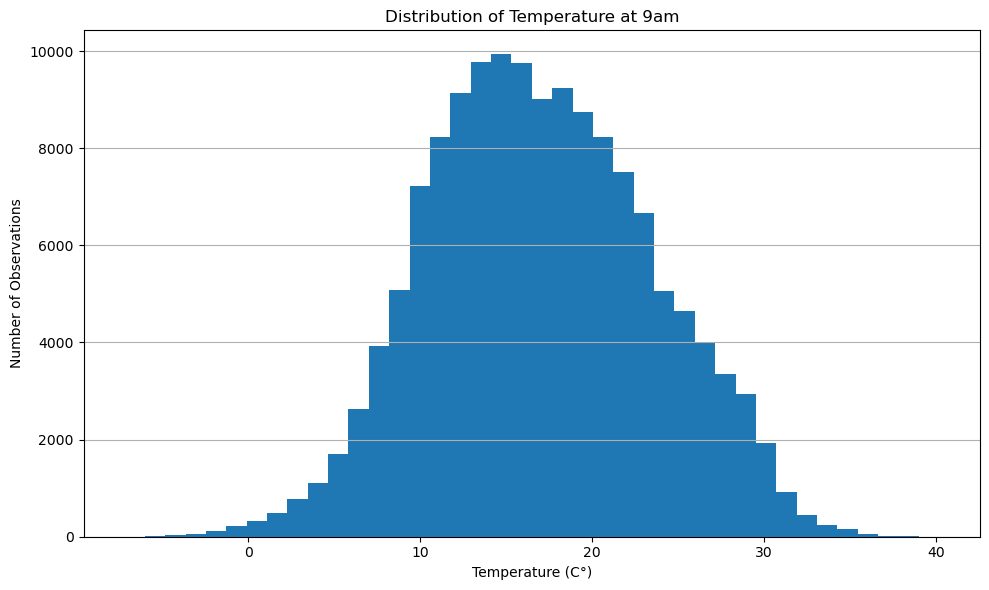

In [51]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Temp9am'], bins=40)
plt.title('Distribution of Temperature at 9am')
plt.xlabel('Temperature (C°)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Temperature 3pm

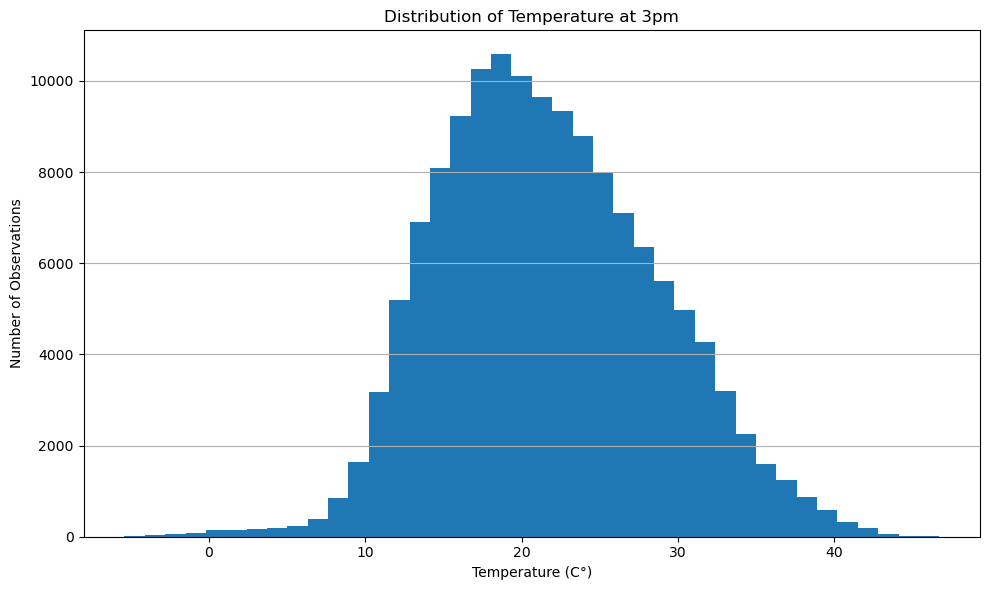

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(x=df_eda['Temp3pm'], bins=40)
plt.title('Distribution of Temperature at 3pm')
plt.xlabel('Temperature (C°)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Bivariate Analysis

### Correlation Analysis

In [53]:
df_corr = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, ax=ax, linewidth =.5,annot_kws={"fontsize":16})

NameError: name 'numeric_df' is not defined

<a id='section4'></a>
## 4. Data Preprocessing
- Handle missing values
- Encode categorical variables
- Scale numerical variables
- Train-test split


Aissata: Detecting high cardinality in categorical features here (useful in order to optimize the training of our models).

In [ ]:
# Detect nominal features with high-cardinality
HIGH_CARDINALITY_THRESHOLD = 10
high_card_features = [
    (col, df[col].nunique())
    for col in categorical_features
    if df[col].nunique() > HIGH_CARDINALITY_THRESHOLD
]

# Separate low/high-cardinality nominal columns
low_card_features = [col for col in categorical_features if col not in [c for c, _ in high_card_features]]
high_card_features_names = [col for col, _ in high_card_features]

print("High-cardinality features:", high_card_features_names)
print("Low-cardinality features: ",low_card_features)

High-cardinality features: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Low-cardinality features:  ['RainToday']


<a id="split-data"></a>
#### 4.1 Split Data into Test and Validation Sets

In [ ]:
df = df.dropna(subset=[target])   # drop rows with missing target
# Define features matrix X and target vector y
y = df[target]
X = df.drop(columns=[target])

# First split into (train + val) and test sets - 80% (train + val), 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # or use stratify=y because target is categorical/imbalanced
)

# Then split again (train + val) into train and validation sets - 75% train, 25% val of remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data for validation
    random_state=42,
    stratify=y_train_val
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 85315
Validation size: 28439
Test size: 28439


<a id="target-preparation"></a>
### 4.2 Target Data Preparation

Aissata: not sure if necessary.

<a id="features-preprocessing"></a>
### 4.3 Features Preprocessing

<a id='section5'></a>
## 5. Model Selection
- Try several baseline models
- Logistic Regression, Random Forest, SVM, etc.


<a id='section6'></a>
## 6. Model Training & Evaluation

<a id='section7'></a>
## 7. Hyperparameter Tuning
- GridSearchCV / RandomizedSearchCV


<a id='section8'></a>
## 8. Final Evaluation & Model Saving

<a id='section9'></a>
## 9. Feature Importance / Explainability


<a id='section10'></a>
## 10. Conclusions & Next Steps